# Providing dynamic efficiency threshold as function

## Idea

We can give the efficiency threshold as a function with the signature:

```python
def eta_r(t,oe,mass,battery):
    # ... compute eta as a function of the inputs ...
    return eta_r
```

For example, this can be a function based on the battery level:

```python
def eta_r(t,oe,mass,battery):
    return min(400/(4*battery - battery_dod), 1)
```

## Demonstration

We first do our imports and define the initial/final state and weights


In [2]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import time

import sys
sys.path.append("../../../")    # path to pyqlaw
import pyqlaw

In [3]:
# initial and final elements: [a,e,i,RAAN,omega,ta]
LU = 42164.0
GM_EARTH = 398600.44
VU = np.sqrt(GM_EARTH/LU)
TU = LU/VU

rp_gto = 200 + 6378
ra_gto = 35786 + 6378
sma_gto = (rp_gto + ra_gto)/(2*LU)
ecc_gto = (ra_gto - rp_gto)/(ra_gto + rp_gto)
KEP0 = [sma_gto,ecc_gto,np.deg2rad(23),0,0,0]
KEPF = [1,0,np.deg2rad(3),0,0,0]
oe0 = pyqlaw.kep2mee_with_a(np.array(KEP0))
oeT = pyqlaw.kep2mee_with_a(np.array(KEPF))
woe = [3.0, 1.0, 1.0, 1.0, 1.0]

# spacecraft parameters
MU = 1500
tmax_si = 1.0    # 1 N
isp_si  = 1500   # seconds
mdot_si = tmax_si/(isp_si*9.81)  # kg/s

# non-dimensional quantities
mass0 = 1.0
tmax = tmax_si * (1/MU)*(TU**2/(1e3*LU))
mdot = np.abs(mdot_si) *(TU/MU)
tf_max = 10000.0
t_step = np.deg2rad(15)

Suppose we want to define eta as a function of battery; we define some battery related quantities


In [4]:
# battery levels
battery_initial = 3000*3600/TU            # Wh --> Ws --> W.TU
battery_dod = 500*3600/TU
battery_capacity = (battery_dod,battery_initial)
charge_rate = 1500          # W
discharge_rate = 500        # W
battery_charge_discharge_rate = (charge_rate, discharge_rate)
require_full_recharge = True

We now construct the `QLaw` object, and set the problem with information about the battery. 

In [5]:
# construct problem
prob = pyqlaw.QLaw(
    integrator="rk4", 
    elements_type="mee_with_a",
    verbosity=2,
    print_frequency=500,
    use_sundman = True,
)

# set problem
prob.set_problem(oe0, oeT, mass0, tmax, mdot, tf_max, t_step,
    battery_initial = battery_initial,
    battery_capacity = battery_capacity,
    battery_charge_discharge_rate = battery_charge_discharge_rate,
    require_full_recharge = require_full_recharge,
    woe = woe)
prob.pretty()

Transfer:
  a  : 5.7800e-01 -> 1.0000e+00 (weight: 3.00)
  f  : 7.3009e-01 -> 0.0000e+00 (weight: 1.00)
  g  : 0.0000e+00 -> 0.0000e+00 (weight: 1.00)
  h  : 2.0345e-01 -> 2.6186e-02 (weight: 1.00)
  k  : 0.0000e+00 -> 0.0000e+00 (weight: 1.00)


We now define the functions `eta_a()` and `eta_r()` that will be called at each step of the integration. Here, we make use of the relative efficiency only, so the `eta_a()` function is merely a placeholder (we might as well pass `eta_a=0.0` later), but is still defined as a function for the sake of demonstration. 

In [7]:
# efficiency functions
def eta_a(t,oe,mass,battery):
    return 0.0    # not using absolute efficiency threshold

def eta_r(t,oe,mass,battery):
    return min(400/(4*battery - battery_dod), 1)

Finally, we call the `solve()` method of `prob`, passing the functions `eta_a` and `eta_r` as arguments

In [9]:
# solve
tstart_solve = time.time()
prob.solve(eta_a=eta_a, eta_r=eta_r)
prob.pretty_results()


 iter   |  time      |  del1       |  del2       |  del3       |  del4       |  del5       |  el6        |
      0 |  3.201e-02 | -4.2191e-01 |  7.3013e-01 |  0.0000e+00 |  1.7725e-01 |  0.0000e+00 |  1.9240e-01 |
    500 |  5.397e+01 | -3.9395e-01 |  7.3353e-01 |  1.1752e-02 |  1.7309e-01 |  1.7783e-03 |  1.4051e+02 |
   1000 |  1.136e+02 | -3.6677e-01 |  7.3354e-01 |  2.9993e-02 |  1.6822e-01 |  4.6323e-03 |  2.7918e+02 |
   1500 |  1.757e+02 | -3.4198e-01 |  7.3171e-01 |  4.7431e-02 |  1.6313e-01 |  7.5286e-03 |  4.1131e+02 |
   2000 |  2.411e+02 | -3.1986e-01 |  7.2714e-01 |  6.5952e-02 |  1.5742e-01 |  1.1059e-02 |  5.4133e+02 |
   2500 |  3.095e+02 | -2.9652e-01 |  7.1927e-01 |  9.0385e-02 |  1.5101e-01 |  1.5398e-02 |  6.6781e+02 |
   3000 |  3.847e+02 | -2.6599e-01 |  7.0687e-01 |  1.2310e-01 |  1.4264e-01 |  2.0945e-02 |  7.9495e+02 |
   3500 |  4.644e+02 | -2.3906e-01 |  6.9265e-01 |  1.4845e-01 |  1.3443e-01 |  2.5652e-02 |  9.2098e+02 |
   4000 |  5.442e+02 | -2.1431e-01 |

and we can visualize the results

Using 8000 steps for evaluation


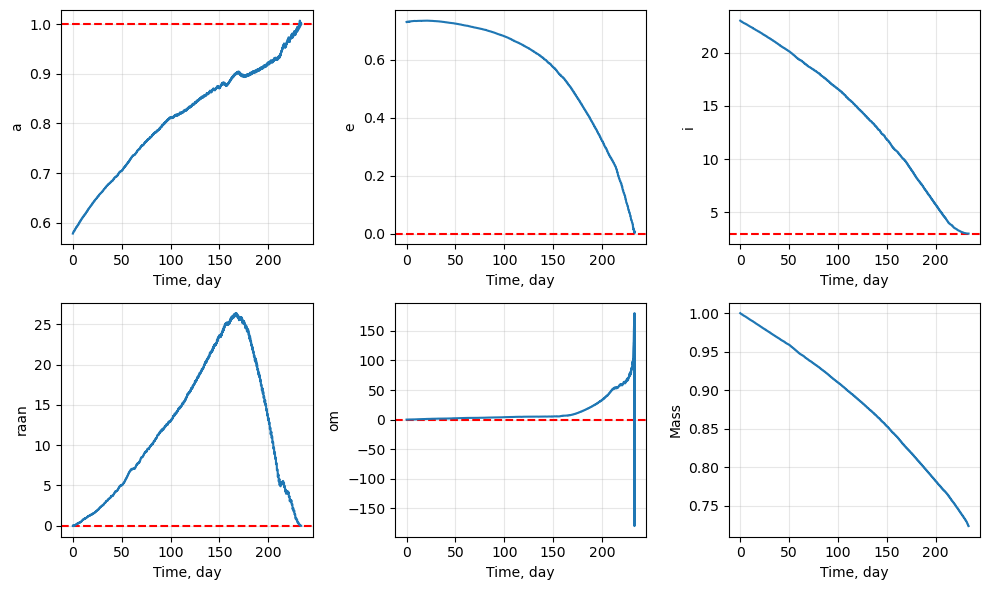

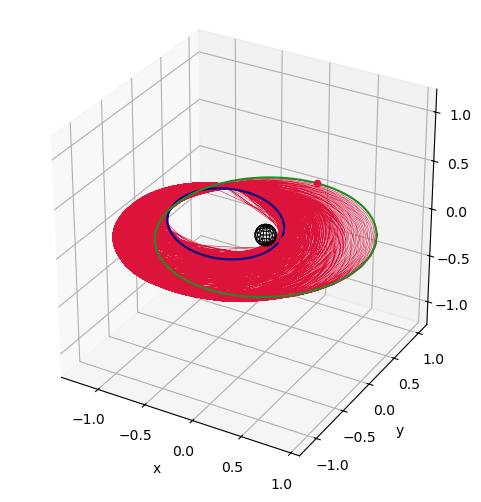

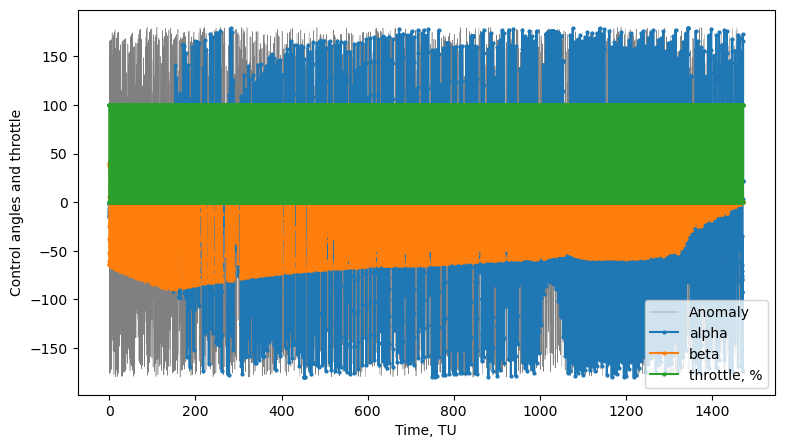

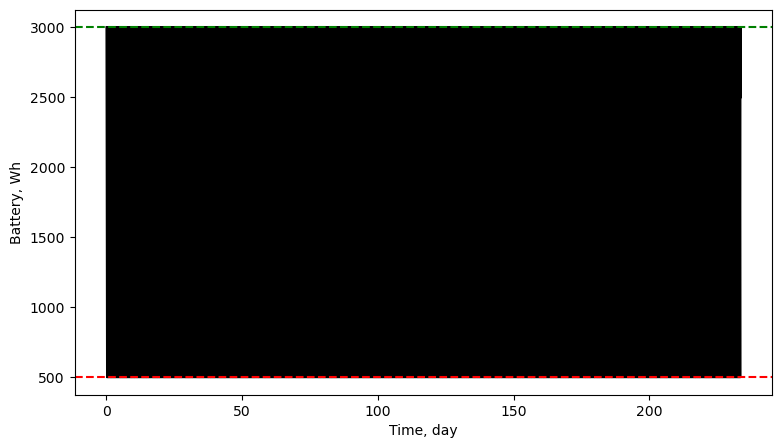

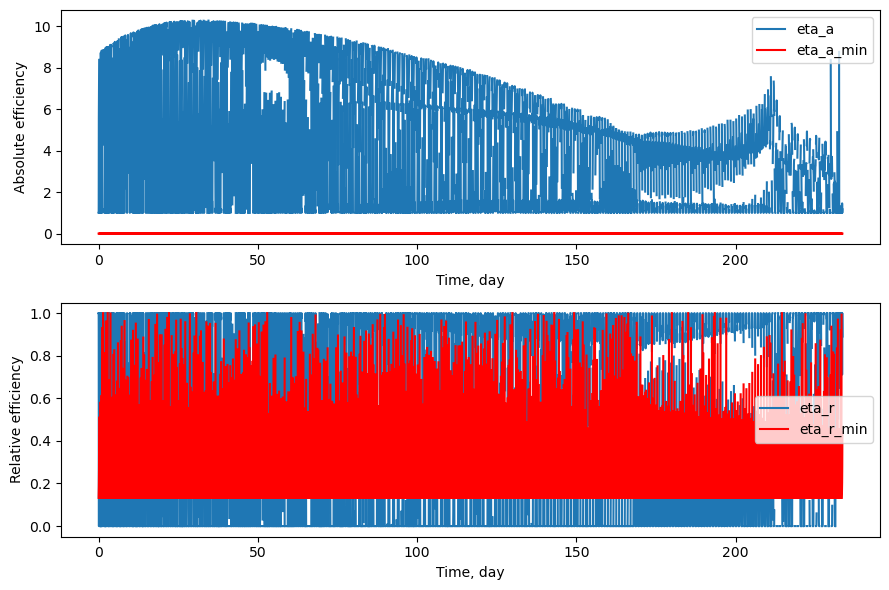

In [10]:
# plots
fig1, ax1 = prob.plot_elements_history(to_keplerian=True, TU=TU/86400, time_unit_name="day")
fig2, ax2 = prob.plot_trajectory_3d(sphere_radius=0.1)
fig3, ax3 = prob.plot_controls()
fig4, ax4 = prob.plot_battery_history(TU=TU/86400, BU=TU/3600,
    time_unit_name="day", battery_unit_name="Wh")
fig5, ax5 = prob.plot_efficiency(TU=TU/86400, time_unit_name="day")
plt.show()